In [1]:
# All the imports
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

os.makedirs("images", exist_ok=True)

try:
  import wandb
except:
  # WandB – Install the W&B library
  !pip install wandb -q
  import wandb

In [2]:


latent_dim = 100
img_size = 32
channels = 1


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),

            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),

            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        # print("Genrator out shape before reshape",out.shape)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        # print("Genrator out shape after reshape",out.shape)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 16, 3, 2, 1), 
            nn.LeakyReLU(0.2, inplace=True), 
            # nn.Dropout2d(0.25),

            nn.Conv2d(16, 32, 3, 2, 1), 
            nn.LeakyReLU(0.2, inplace=True), 
            # nn.Dropout2d(0.25),
            # nn.BatchNorm2d(32, 0.8),

            nn.Conv2d(32, 64, 3, 2, 1), 
            nn.LeakyReLU(0.2, inplace=True), 
            # nn.Dropout2d(0.25),
            # nn.BatchNorm2d(64, 0.8),

            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.LeakyReLU(0.2, inplace=True), 
            # nn.Dropout2d(0.25),
            nn.BatchNorm2d(128, 0.8),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        # print("Discriminator out shape before reshape",out.shape)
        out = out.view(out.shape[0], -1)
        # print("Discriminator out shape after reshape",out.shape)
        validity = self.adv_layer(out)

        return validity

In [3]:
batch_size = 100
path_data = "/content"

transform1 = transforms.Compose([transforms.Resize(img_size), 
                                 transforms.ToTensor(), 
                                 transforms.Normalize([0.5], [0.5])])
dataset_mnist = datasets.MNIST(path_data,train=True,download=True,
                                                         transform=transform1)



dataloader = torch.utils.data.DataLoader( dataset_mnist,batch_size=batch_size,shuffle=True)

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw
Processing...



Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
lr = 0.0001
b1 = 0.5
b2 = 0.999

# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()


generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

# Initialize weights
# generator.apply(weights_init_normal)
# discriminator.apply(weights_init_normal)

# Optimizers
# optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)
if device == 'cuda':
  Tensor = torch.cuda.FloatTensor 
else:
  Tensor = torch.FloatTensor

cuda


In [5]:
print(generator)
print(discriminator)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, i

In [5]:
# Enter your api key in the second last line (the command is !wandb login <apikey>) and set your project name variable accordingly.
flag_wandb_log_status = False
wandb_run_name = "n0_batchnorm" + str(latent_dim) + "LS"

project_name = ""

# WandB – Login to your wandb account so you can log all your metrics
if(flag_wandb_log_status == True):
  !wandb login 
  run_object = wandb.init(name = wandb_run_name,project=project_name)

     |████████████████████████████████| 1.8MB 12.2MB/s 
     |████████████████████████████████| 102kB 12.2MB/s 
     |████████████████████████████████| 133kB 50.0MB/s 
     |████████████████████████████████| 102kB 11.7MB/s 
     |████████████████████████████████| 163kB 46.3MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: riteshchowdhry (use `wandb login --relogin` to force relogin)


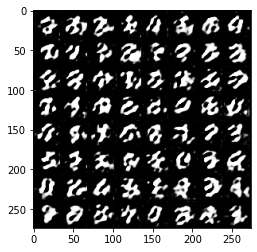

[Epoch 0/100]  [D loss: 0.672644] [G loss: 0.747514]


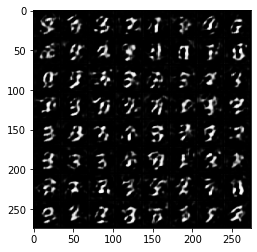

[Epoch 1/100]  [D loss: 0.685510] [G loss: 0.729168]


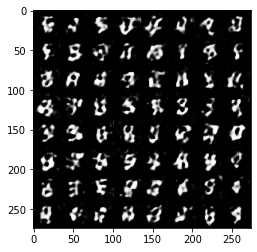

[Epoch 2/100]  [D loss: 0.684921] [G loss: 0.708908]


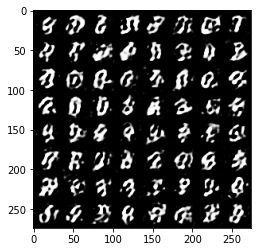

[Epoch 3/100]  [D loss: 0.662828] [G loss: 0.755516]


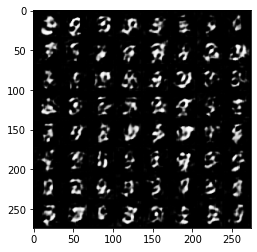

[Epoch 4/100]  [D loss: 0.668776] [G loss: 0.742279]


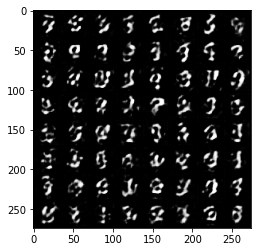

[Epoch 5/100]  [D loss: 0.664685] [G loss: 0.766743]


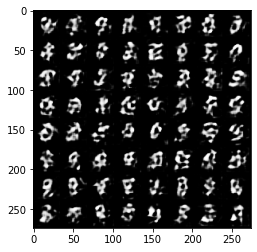

[Epoch 6/100]  [D loss: 0.649933] [G loss: 0.794214]


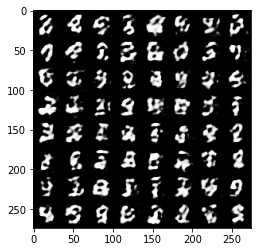

[Epoch 7/100]  [D loss: 0.666244] [G loss: 0.768526]


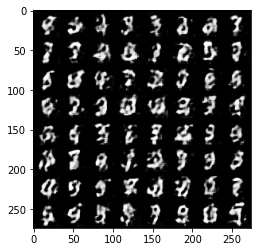

[Epoch 8/100]  [D loss: 0.649615] [G loss: 0.787053]


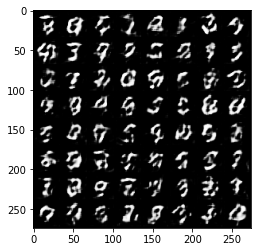

[Epoch 9/100]  [D loss: 0.629954] [G loss: 0.826715]


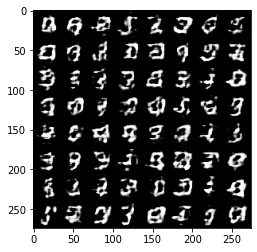

[Epoch 10/100]  [D loss: 0.621242] [G loss: 0.824023]


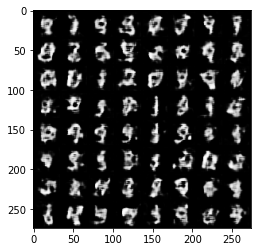

[Epoch 11/100]  [D loss: 0.498437] [G loss: 1.101805]


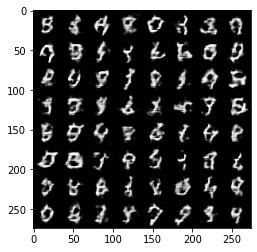

[Epoch 12/100]  [D loss: 0.456589] [G loss: 1.169421]


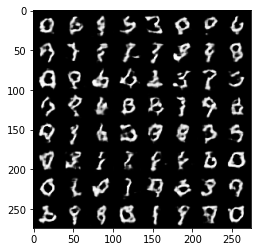

[Epoch 13/100]  [D loss: 0.481072] [G loss: 1.120922]


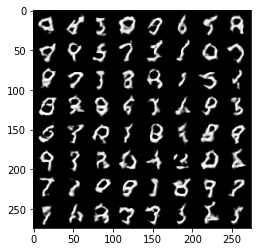

[Epoch 14/100]  [D loss: 0.519431] [G loss: 1.034749]


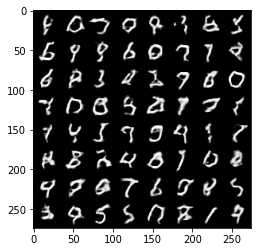

[Epoch 15/100]  [D loss: 0.530336] [G loss: 0.993134]


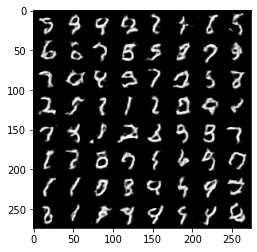

[Epoch 16/100]  [D loss: 0.515054] [G loss: 1.035958]


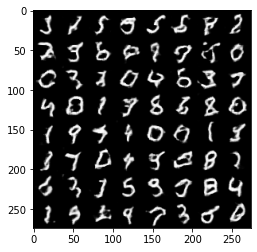

[Epoch 17/100]  [D loss: 0.525586] [G loss: 1.019050]


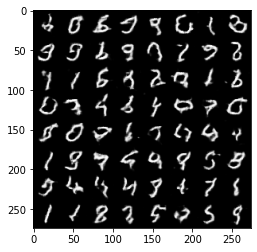

[Epoch 18/100]  [D loss: 0.534698] [G loss: 0.999882]


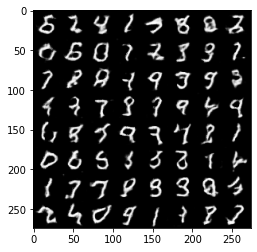

[Epoch 19/100]  [D loss: 0.504719] [G loss: 1.062514]


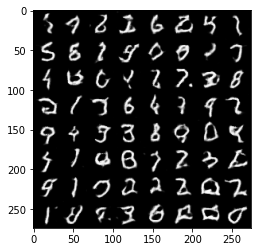

[Epoch 20/100]  [D loss: 0.500543] [G loss: 1.080341]


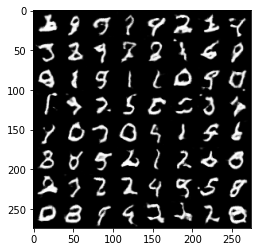

[Epoch 21/100]  [D loss: 0.485778] [G loss: 1.094847]


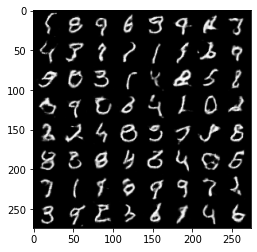

[Epoch 22/100]  [D loss: 0.476352] [G loss: 1.117117]


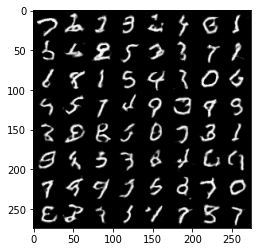

[Epoch 23/100]  [D loss: 0.472072] [G loss: 1.143605]


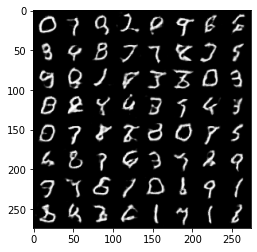

[Epoch 24/100]  [D loss: 0.457330] [G loss: 1.166717]


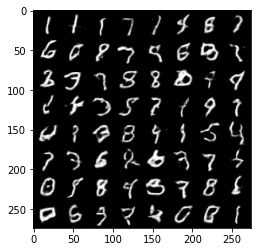

[Epoch 25/100]  [D loss: 0.449021] [G loss: 1.184802]


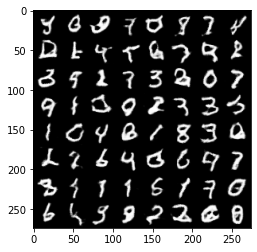

[Epoch 26/100]  [D loss: 0.445807] [G loss: 1.203646]


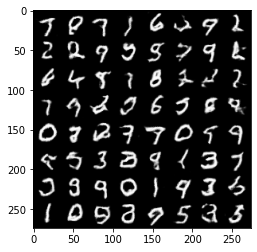

[Epoch 27/100]  [D loss: 0.437811] [G loss: 1.223875]


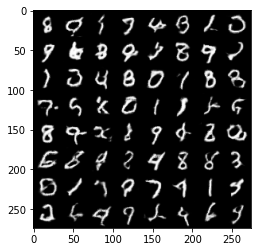

[Epoch 28/100]  [D loss: 0.438367] [G loss: 1.223736]


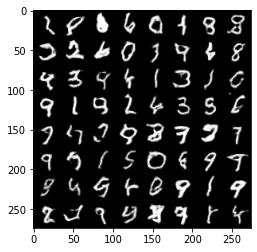

[Epoch 29/100]  [D loss: 0.431808] [G loss: 1.228276]


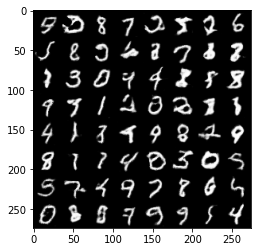

[Epoch 30/100]  [D loss: 0.425943] [G loss: 1.255487]


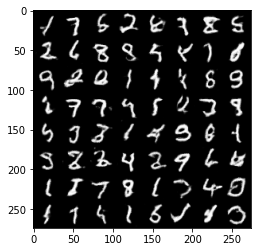

[Epoch 31/100]  [D loss: 0.420934] [G loss: 1.264427]


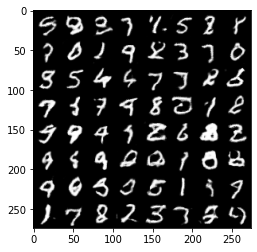

[Epoch 32/100]  [D loss: 0.415709] [G loss: 1.300228]


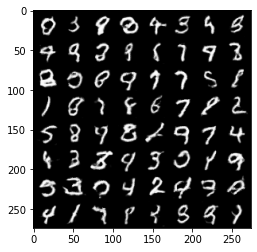

[Epoch 33/100]  [D loss: 0.407433] [G loss: 1.314800]


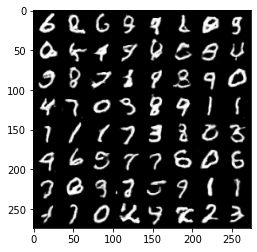

[Epoch 34/100]  [D loss: 0.406262] [G loss: 1.332606]


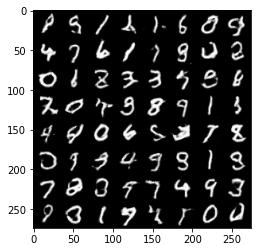

[Epoch 35/100]  [D loss: 0.393478] [G loss: 1.357106]


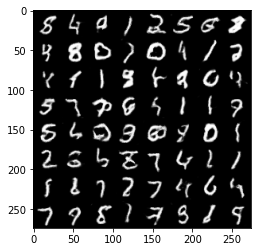

[Epoch 36/100]  [D loss: 0.386623] [G loss: 1.374137]


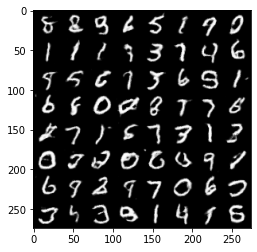

[Epoch 37/100]  [D loss: 0.387628] [G loss: 1.392997]


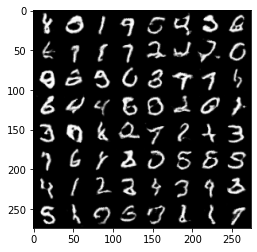

[Epoch 38/100]  [D loss: 0.377421] [G loss: 1.411783]


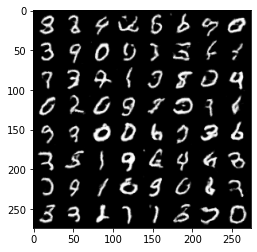

[Epoch 39/100]  [D loss: 0.363760] [G loss: 1.456220]


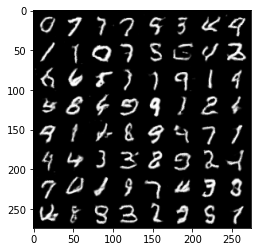

[Epoch 40/100]  [D loss: 0.366750] [G loss: 1.470158]


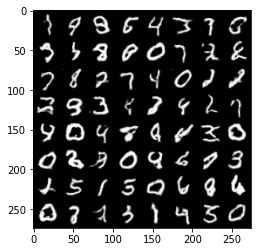

[Epoch 41/100]  [D loss: 0.354046] [G loss: 1.487895]


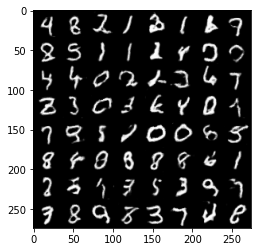

[Epoch 42/100]  [D loss: 0.355488] [G loss: 1.518382]


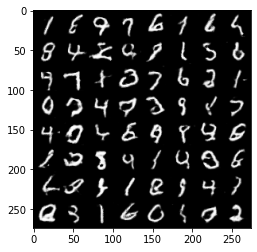

[Epoch 43/100]  [D loss: 0.357681] [G loss: 1.521778]


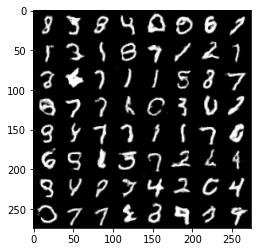

[Epoch 44/100]  [D loss: 0.348465] [G loss: 1.538086]


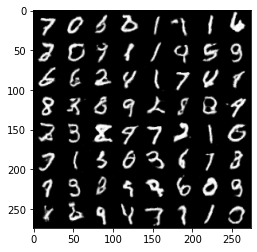

[Epoch 45/100]  [D loss: 0.337993] [G loss: 1.562800]


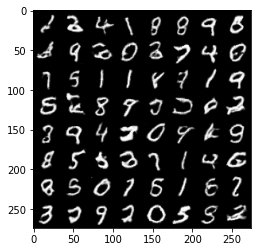

[Epoch 46/100]  [D loss: 0.333958] [G loss: 1.582255]


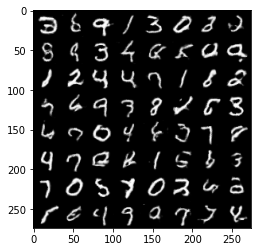

[Epoch 47/100]  [D loss: 0.330952] [G loss: 1.619942]


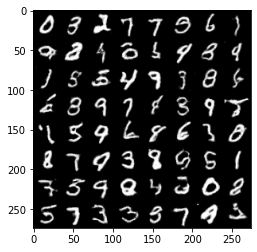

[Epoch 48/100]  [D loss: 0.326801] [G loss: 1.625807]


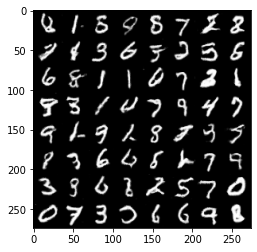

[Epoch 49/100]  [D loss: 0.316606] [G loss: 1.654139]


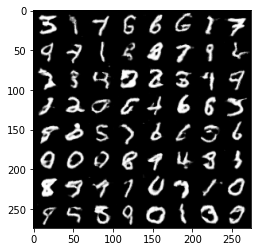

[Epoch 50/100]  [D loss: 0.319098] [G loss: 1.676900]


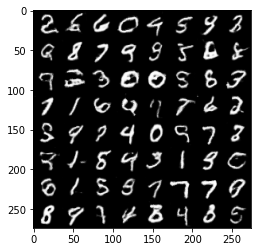

[Epoch 51/100]  [D loss: 0.303793] [G loss: 1.681128]


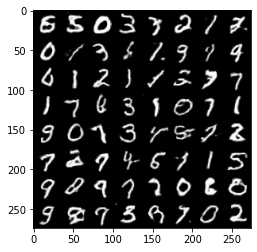

[Epoch 52/100]  [D loss: 0.308268] [G loss: 1.726936]


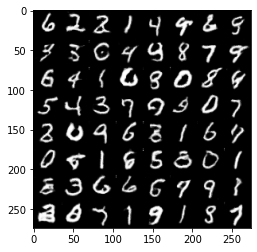

[Epoch 53/100]  [D loss: 0.312414] [G loss: 1.744944]


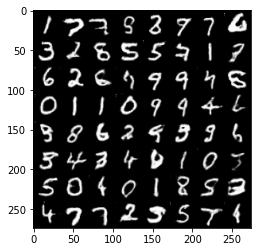

[Epoch 54/100]  [D loss: 0.300510] [G loss: 1.753858]


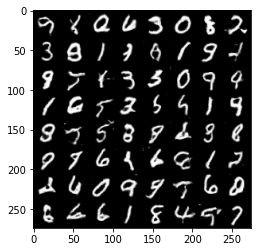

[Epoch 55/100]  [D loss: 0.303760] [G loss: 1.765623]


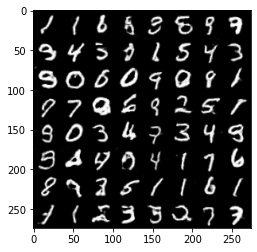

[Epoch 56/100]  [D loss: 0.284463] [G loss: 1.817126]


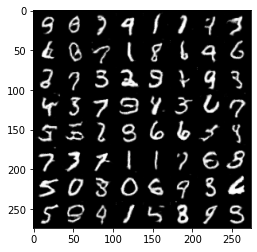

[Epoch 57/100]  [D loss: 0.290706] [G loss: 1.808004]


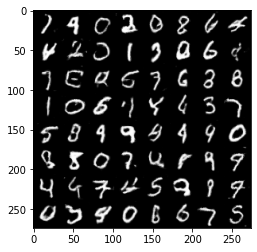

[Epoch 58/100]  [D loss: 0.286115] [G loss: 1.828086]


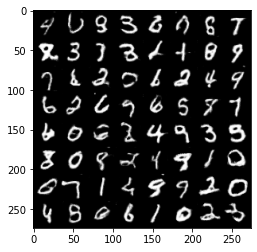

[Epoch 59/100]  [D loss: 0.282362] [G loss: 1.881175]


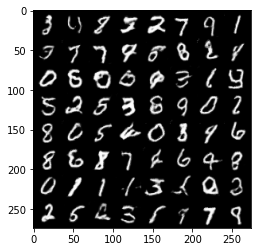

[Epoch 60/100]  [D loss: 0.276055] [G loss: 1.887584]


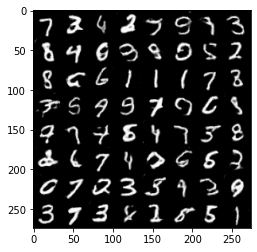

[Epoch 61/100]  [D loss: 0.271210] [G loss: 1.919998]


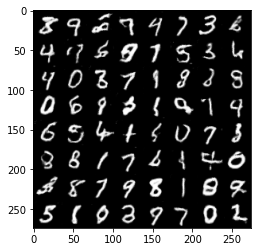

[Epoch 62/100]  [D loss: 0.263728] [G loss: 1.952233]


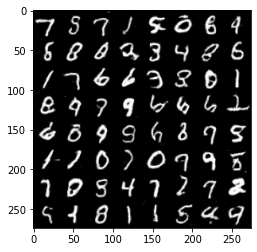

[Epoch 63/100]  [D loss: 0.260675] [G loss: 1.947140]


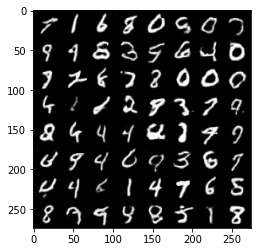

[Epoch 64/100]  [D loss: 0.260329] [G loss: 1.977210]


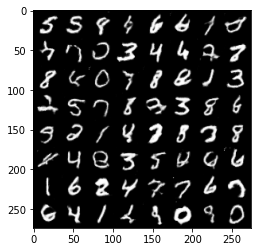

[Epoch 65/100]  [D loss: 0.263506] [G loss: 2.020009]


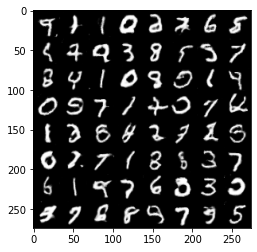

[Epoch 66/100]  [D loss: 0.254302] [G loss: 2.010798]


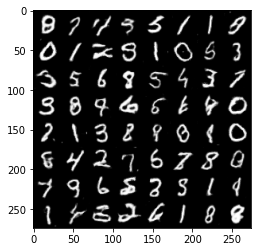

[Epoch 67/100]  [D loss: 0.255360] [G loss: 2.043529]


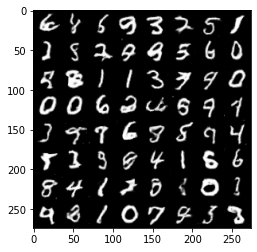

[Epoch 68/100]  [D loss: 0.248137] [G loss: 2.080101]


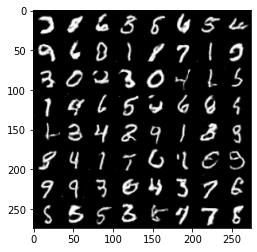

[Epoch 69/100]  [D loss: 0.238340] [G loss: 2.071137]


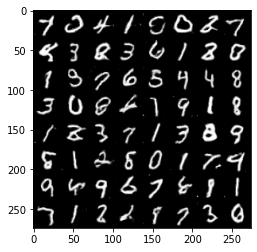

[Epoch 70/100]  [D loss: 0.245739] [G loss: 2.105732]


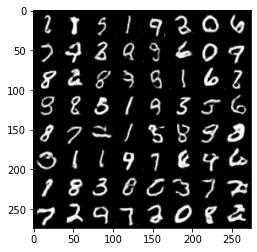

[Epoch 71/100]  [D loss: 0.233747] [G loss: 2.140466]


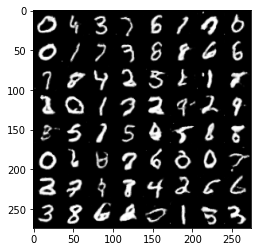

[Epoch 72/100]  [D loss: 0.240597] [G loss: 2.146313]


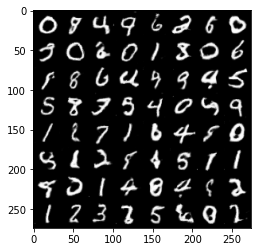

[Epoch 73/100]  [D loss: 0.230471] [G loss: 2.166915]


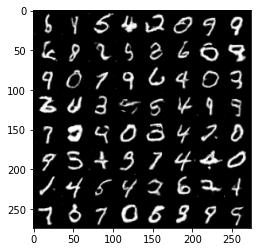

[Epoch 74/100]  [D loss: 0.240794] [G loss: 2.198299]


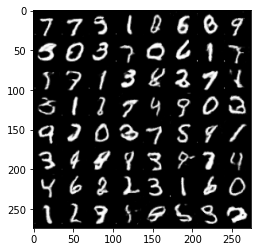

[Epoch 75/100]  [D loss: 0.235839] [G loss: 2.233050]


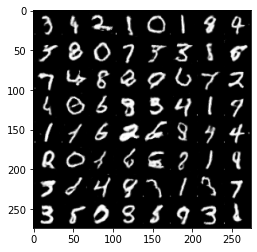

[Epoch 76/100]  [D loss: 0.218333] [G loss: 2.231199]


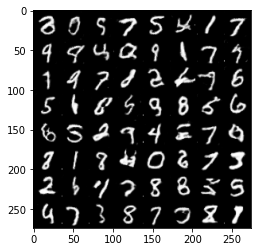

[Epoch 77/100]  [D loss: 0.223284] [G loss: 2.242013]


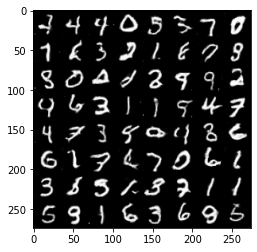

[Epoch 78/100]  [D loss: 0.226132] [G loss: 2.282935]


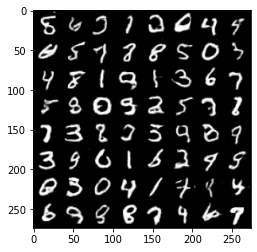

[Epoch 79/100]  [D loss: 0.218191] [G loss: 2.253645]


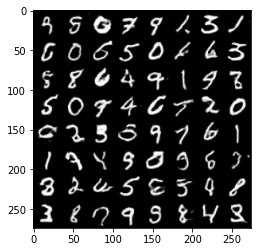

[Epoch 80/100]  [D loss: 0.212927] [G loss: 2.302469]


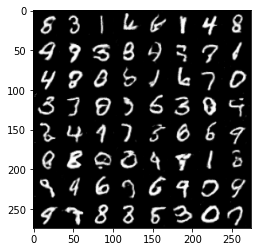

[Epoch 81/100]  [D loss: 0.208497] [G loss: 2.337232]


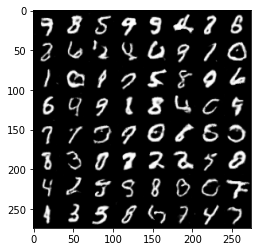

[Epoch 82/100]  [D loss: 0.212321] [G loss: 2.355708]


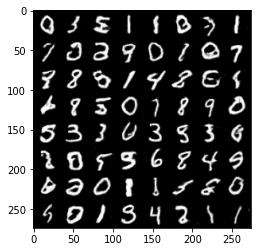

[Epoch 83/100]  [D loss: 0.219492] [G loss: 2.405248]


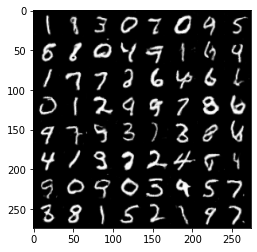

[Epoch 84/100]  [D loss: 0.196955] [G loss: 2.377683]


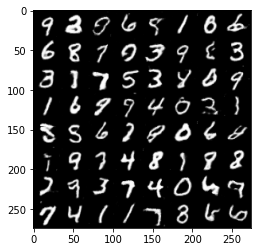

[Epoch 85/100]  [D loss: 0.223852] [G loss: 2.417698]


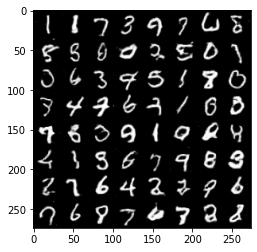

[Epoch 86/100]  [D loss: 0.193694] [G loss: 2.424690]


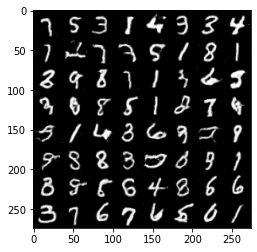

[Epoch 87/100]  [D loss: 0.200643] [G loss: 2.431870]


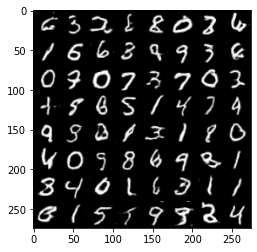

[Epoch 88/100]  [D loss: 0.196976] [G loss: 2.464602]


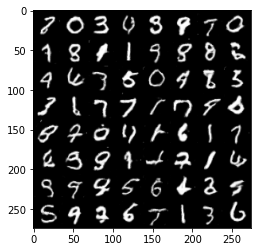

[Epoch 89/100]  [D loss: 0.208865] [G loss: 2.513328]


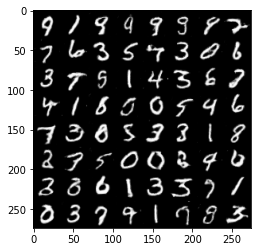

[Epoch 90/100]  [D loss: 0.199505] [G loss: 2.519904]


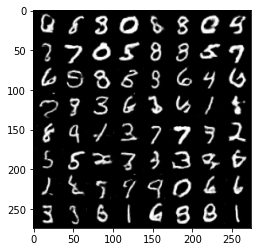

[Epoch 91/100]  [D loss: 0.192822] [G loss: 2.498876]


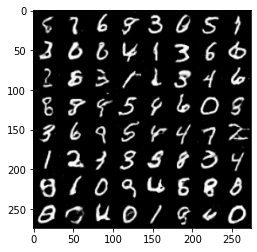

[Epoch 92/100]  [D loss: 0.215836] [G loss: 2.535827]


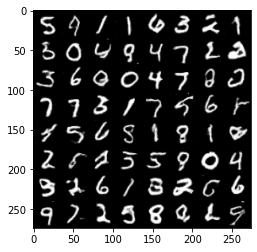

[Epoch 93/100]  [D loss: 0.188884] [G loss: 2.550682]


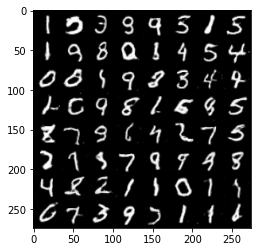

[Epoch 94/100]  [D loss: 0.176285] [G loss: 2.582467]


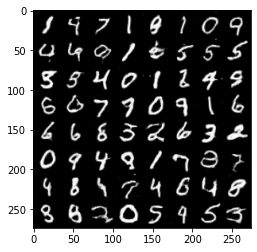

[Epoch 95/100]  [D loss: 0.187309] [G loss: 2.594481]


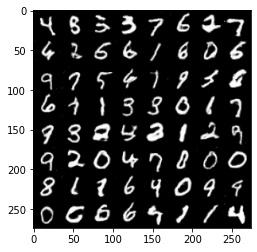

[Epoch 96/100]  [D loss: 0.179799] [G loss: 2.614322]


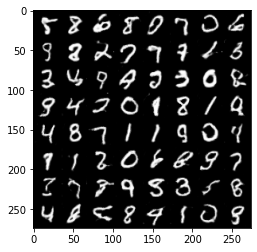

[Epoch 97/100]  [D loss: 0.200147] [G loss: 2.642673]


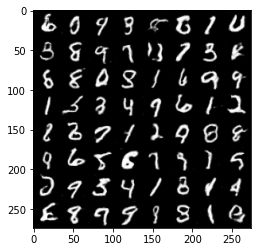

[Epoch 98/100]  [D loss: 0.172609] [G loss: 2.660446]


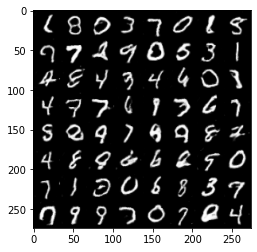

[Epoch 99/100]  [D loss: 0.169410] [G loss: 2.663205]


In [6]:
# flag_wandb_log_status = False
wandb_log_status = flag_wandb_log_status
try:
  if(wandb_log_status == True):
    wandb.watch(generator, log="all")
except:  
  pass
try:
  if(wandb_log_status == True):
    wandb.watch(discriminator, log="all")
except:  
  pass


n_epochs = 100
for epoch in range(n_epochs): 
  g_mean_loss = 0
  d_mean_loss = 0
  for i, (imgs, _) in enumerate(dataloader):
    # Adversarial ground truths
    valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
    fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

    # Configure input
    real_imgs = Variable(imgs.type(Tensor))
    #  Train Generator

    optimizer_G.zero_grad()

    # Sample noise as generator input
    z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

    # Generate a batch of images
    gen_imgs = generator(z)

    # Loss measures generator's ability to fool the discriminator
    g_loss = adversarial_loss(discriminator(gen_imgs), valid)

    g_loss.backward()
    optimizer_G.step()
    #  Train Discriminator
    optimizer_D.zero_grad()

    # Measure discriminator's ability to classify real from generated samples
    real_loss = adversarial_loss(discriminator(real_imgs), valid)
    fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    optimizer_D.step()
    batches_done = epoch * len(dataloader) + i
    g_mean_loss += g_loss.item() 
    d_mean_loss += d_loss.item()
  if(wandb_log_status == True):
    wandb.log({"Generator Loss": g_mean_loss/len(dataloader)})
  if(wandb_log_status == True):
    wandb.log({"discriminator Loss": d_mean_loss/len(dataloader)})
    # break



  save_image(gen_imgs.data[:64], "images/%d.png" % epoch, nrow=8, normalize=True)
  # plt.imshow(gen_imgs.data[:25])
  name = "/content/images/" + str(epoch) +".png"
  img = mpimg.imread(name)
  imgplot = plt.imshow(img)
  plt.show()
  print("[Epoch %d/%d]  [D loss: %f] [G loss: %f]"% (epoch, n_epochs, d_mean_loss/len(dataloader), g_mean_loss/len(dataloader)))

if(flag_wandb_log_status == True):
  run_object.finish()

In [53]:
PATH = '/content/generator'
PATH_D = '/content/discriminator'
torch.save(generator.state_dict(), PATH)
torch.save(discriminator.state_dict(), PATH_D)

torch.Size([64, 1, 32, 32])


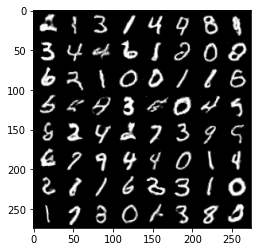

torch.Size([64, 1, 32, 32])


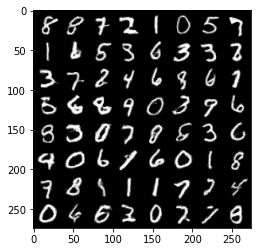

torch.Size([64, 1, 32, 32])


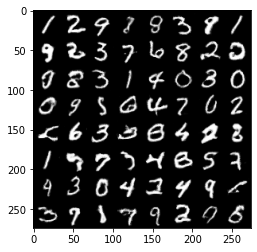

torch.Size([64, 1, 32, 32])


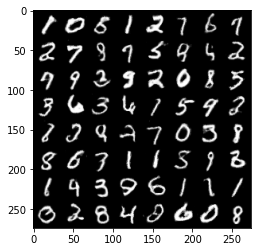

torch.Size([64, 1, 32, 32])


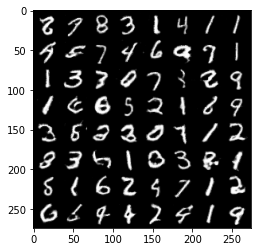

torch.Size([64, 1, 32, 32])


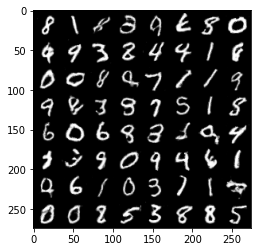

torch.Size([64, 1, 32, 32])


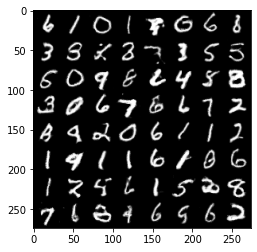

torch.Size([64, 1, 32, 32])


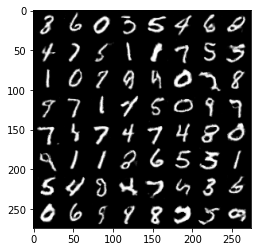

torch.Size([64, 1, 32, 32])


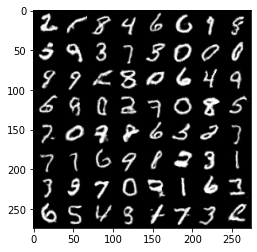

torch.Size([64, 1, 32, 32])


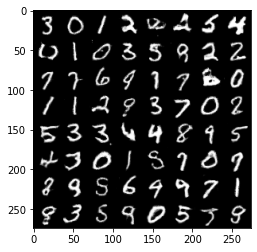

In [63]:
for i in range(10):
  with torch.no_grad():
    z = Variable(Tensor(np.random.normal(0, 1, (64, latent_dim))))
    # Generate a batch of images
    gen_imgs = (generator(z)).cpu()
    # load model
    print(gen_imgs.shape)
    save_image(gen_imgs.data[:64], "%d.png" % epoch, nrow=8, normalize=True)
    img = mpimg.imread('/content/99.png')
    imgplot = plt.imshow(img[:,:,0], cmap='binary_r')
    plt.show()
